In [1]:

import random
import numpy as np

class NeuralNetwork(object):
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.weights = [np.random.randn(y, x+1) \
                        for x, y in zip((sizes[:-1]), sizes[1:])] # biases are included in weights
    
    
    def feedforward(self, a):

        for w in self.weights:
            a = np.concatenate((a,np.array([1]).reshape(1,1))) # add bias neuron 
            a = sigmoid(np.dot(w, a))
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):

        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] \
                            for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format( \
                    j, self.evaluate_0(test_data), n_test))
            else:
                print ("Epoch {0} complete".format(j))   
                
    def update_mini_batch(self, mini_batch, eta):

        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_w = self.backprop(x, y)             
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
  
                
    def backprop(self, x, y):

        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [activation] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for w in self.weights:
            activation = np.concatenate((activation,np.array([1]).reshape(1,1)))
            activations[-1]=activation
            z = np.dot(w, activation)
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
                                     sigmoid_prime(zs[-1])
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta)[:-1]
            delta = delta * sp
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_w                
                
    def evaluate_0(self, test_data):

        test_results = [(int(self.feedforward(x)[1][0]>0.1), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results) 
                
    def evaluate(self, test_data):

        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)  


    def cost_derivative(self, output_activations, y):

        return (output_activations-y)


#### Miscellaneous functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))




In [2]:

import pandas as pd

car_data=pd.read_csv('car.csv')


car_data = car_data.reindex(columns=['IsBadBuy','Size','Make','VNST','IsOnlineSale','VehicleAge','Transmission',
                             'WheelType','Auction'])


shuffler= np.random.permutation(len(car_data))

car_shuffle = car_data.take(shuffler) # pandas' shuffling method in comparison of random.shuffle

# X preparation

Size = pd.get_dummies(car_data['Size'],prefix='Size')  # generate dummy varibles from categorical varible
Make = pd.get_dummies(car_data['Make'],prefix='Make')
VNST = pd.get_dummies(car_data['VNST'],prefix='VNST')
VehicleAge = pd.get_dummies(car_data['VehicleAge'],prefix='VehicleAge')
WheelType = pd.get_dummies(car_data['WheelType'],prefix='WheelType')
Auction = pd.get_dummies(car_data['Auction'],prefix='Auction')
IsOnlineSale =(car_data.IsOnlineSale=='Yes').apply(float)

X= Size.join(Make).join(VNST).join(IsOnlineSale).join(VehicleAge).join(WheelType).join(Auction)
Y=pd.get_dummies(car_data['IsBadBuy'],prefix='IsBadbuy')

car_training=[(X.iloc[i].values.reshape(93,1),Y.iloc[i].values.reshape(2,1)) for i in X.index]

#test data preparing, as did with training data

car_test=pd.read_csv('car_test.csv')


car_test = car_test.reindex(columns=['IsBadBuy','Size','Make','VNST','IsOnlineSale','VehicleAge','Transmission',
                             'WheelType','Auction'])

Size = pd.get_dummies(car_test['Size'],prefix='Size')  # generate dummy varibles from categorical varible
Make = pd.get_dummies(car_test['Make'],prefix='Make')
VNST = pd.get_dummies(car_test['VNST'],prefix='VNST')
VehicleAge = pd.get_dummies(car_test['VehicleAge'],prefix='VehicleAge')
WheelType = pd.get_dummies(car_test['WheelType'],prefix='WheelType')
Auction = pd.get_dummies(car_test['Auction'],prefix='Auction')
IsOnlineSale =(car_test.IsOnlineSale=='Yes').apply(float)

X= Size.join(Make).join(VNST).join(IsOnlineSale).join(VehicleAge).join(WheelType).join(Auction)
Y=car_test['IsBadBuy']

car_test=[(X.iloc[i].values.reshape(93,1),Y.iloc[i]) for i in X.index]



In [3]:

# set of net for Car training
net = NeuralNetwork([93, 10, 2])
net.SGD(car_training, 10, 50, 1.0)
net.SGD(car_training, 30, 50, 1.0,test_data=car_test)

ProbIsGoodBuy=[net.feedforward(x)[0][0] for (x,y) in car_test]
ProbIsBadBuy=[net.feedforward(x)[1][0] for (x,y) in car_test]


Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 0: 6455 / 10000
Epoch 1: 7023 / 10000
Epoch 2: 5886 / 10000
Epoch 3: 5839 / 10000
Epoch 4: 6962 / 10000
Epoch 5: 6104 / 10000
Epoch 6: 6180 / 10000
Epoch 7: 5477 / 10000
Epoch 8: 6984 / 10000
Epoch 9: 6449 / 10000
Epoch 10: 6846 / 10000
Epoch 11: 6351 / 10000
Epoch 12: 6874 / 10000
Epoch 13: 7048 / 10000
Epoch 14: 6848 / 10000
Epoch 15: 6540 / 10000
Epoch 16: 6580 / 10000
Epoch 17: 6433 / 10000
Epoch 18: 6595 / 10000
Epoch 19: 6497 / 10000
Epoch 20: 5713 / 10000
Epoch 21: 6405 / 10000
Epoch 22: 6413 / 10000
Epoch 23: 6461 / 10000
Epoch 24: 5891 / 10000
Epoch 25: 6533 / 10000
Epoch 26: 7244 / 10000
Epoch 27: 6028 / 10000
Epoch 28: 6527 / 10000
Epoch 29: 6834 / 10000


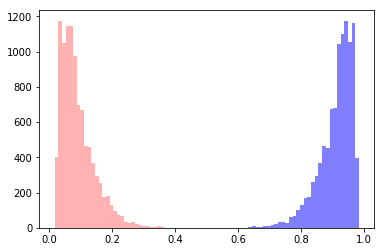

In [5]:

import matplotlib.pyplot as plt

plt.hist(ProbIsBadBuy,bins=30,color='red',alpha=0.3)
plt.hist(ProbIsGoodBuy,bins=30,color='blue',alpha=0.5)
plt.show()


In [6]:

test_result=pd.read_csv('car_test.csv')


test_result = test_result.reindex(columns=['IsBadBuy','Size','Make','VNST','IsOnlineSale','VehicleAge','Transmission',
                             'WheelType','Auction'])


test_result['ProbIsBadBuy']=ProbIsBadBuy


test_result["ProbCat"]=pd.qcut(ProbIsBadBuy,10,precision=1)

#test_result=test_result.sort_values('ProbIsBadBuy')


test_result.groupby("ProbCat").count()
test_result.groupby("ProbCat").sum()

,IsBadBuy,VehicleAge,ProbIsBadBuy
ProbCat,,,
"(0.006, 0.035]",45,2055,29.013961
"(0.035, 0.044]",40,2368,39.190198
"(0.044, 0.055]",69,3074,50.006067
"(0.055, 0.065]",52,3489,60.253614
"(0.065, 0.076]",88,3851,70.290523
"(0.076, 0.088]",86,4219,81.368890
"(0.088, 0.11]",88,4668,96.034174
"(0.11, 0.13]",134,5264,115.492342
"(0.13, 0.16]",142,5833,143.760848


In [10]:
import psycopg2

con= psycopg2.connect(database="cqbus",user="gpadmin",password="gpadmin",host="192.168.0.93",port="5432")

In [7]:
import pandas as pd
df = pd.read_sql('select * from point_data where lng != 0 limit 10;', con=con)
df
#con.close()


,bus,line,occur,lat,lng,v1,v2
0,35557,348中,2014-05-13 09:23:38,106.537,29.4399,35,28
1,5688,559中,2014-05-24 00:04:50,106.430,29.8113,0,0
2,20396,297,2014-05-13 09:25:14,106.458,29.4840,50,186
3,33216,365,2014-05-13 09:24:54,106.504,29.5241,0,0
4,12236,183,2014-05-24 00:03:47,106.520,29.5861,0,0
5,81115,809线,2014-05-24 00:14:31,106.561,29.4753,0,0
6,10721,114,2014-05-13 09:24:24,106.517,29.5851,0,0
7,49126,454,2014-05-13 09:24:24,106.527,29.4967,0,0
8,18512,184,2014-05-13 09:24:39,106.571,29.5627,26,244
9,5561,560路,2014-05-24 00:17:03,106.430,29.8111,0,0


In [11]:
df = pd.read_sql('select * from cqbus2017 limit 10;', con=con)
df
#con.close()

,ticket,org,occur,line,bus,dev,fee,trans
0,4000000007167072,3,2017-01-09 14:53:53,866,82843,400000025369,1.8,0
1,4000000004814166,2,2017-01-09 12:59:35,871,48946,400000030399,1.8,0
2,4000030110170937,301,2017-01-09 07:06:00,138,26175,400000030379,1.0,0
3,4000000210147573,2,2017-01-09 10:01:58,311,38215,400000025326,1.8,0
4,4000030110409327,301,2017-01-09 07:19:41,421,82138,400000024883,1.0,0
5,4000000213222347,2,2017-01-09 06:41:52,309,32615,400000025328,1.8,0
6,4000000211666214,2,2017-01-09 10:28:32,138,26175,400000030379,1.8,0
7,4000000005468478,501,2017-01-09 12:22:25,120,80972,400000025576,1.8,0
8,4000001512151138,15,2017-01-09 05:54:24,821,82430,400000024840,1.8,0
9,4000000220597002,2,2017-01-09 07:30:52,476,48506,400000030428,1.8,0
